In [1]:
import os
import json
import pandas as pd
from matplotlib import pyplot as plt

# Return the earliest date from an array of concert information
def firstConcertDate(concert_array):
    concert_dates = []

    for concert in concert_array:
        concert_dates.append(concert['Date'])

    concert_dates.sort()
    earliest_date = concert_dates[0]

    return earliest_date

In [2]:
# Import New York Phil Performance History from JSON file to a dictionary
perf_history = {}

with open('nyphilarchive_performance_history/Programs/json/complete.json', 'r') as json_file:
    perf_history = json.load(json_file)

perf_history_records = perf_history['programs']

In [52]:
# Convert dictionary from JSON to a DataFrame
perf_df = pd.DataFrame(perf_history_records)

# Create new DataFrame by exploding works column, creating a new row for each work on a program
perf_df_works_exploded = (perf_df
                          .explode('works')
                          .reset_index()
                          )

# Split array of 'works' info into multiple columns and drop redundant fields
works_and_programs = perf_df_works_exploded[['programID', 'works']]
works_dict = works_and_programs.to_dict(orient='records')
works_df = (pd.json_normalize(works_dict, sep='_')
            .drop(['programID', 'works','works_soloists', 'works_conductorName'], axis=1)
            .fillna('')
            )

# Aggregate all 'movement' information into 'works_movement' column
works_df['works_movement__'] = works_df[['works_movement__', 'works_movement_em']].agg(' '.join, axis=1).str.strip()
works_df['works_movement'] = works_df[['works_movement', 'works_movement__']].agg(' '.join, axis=1).str.strip()

# Aggregate all 'workTitle' information into 'works_workTitle' column
works_df['works_workTitle__'] = works_df[['works_workTitle__', 'works_workTitle_em']].agg(' '.join, axis=1).str.strip()
works_df['works_workTitle'] = works_df[['works_workTitle', 'works_workTitle__']].agg(' '.join, axis=1).str.strip()

# Change column names to singular/lowercase
works_df_cleaned = (works_df
                    .rename(columns={
                        'works_ID' : "work_id",
                        "works_composerName" : "work_composer_name",
                        "works_workTitle" : "work_title",
                        "works_movement" : "work_movement"})
                    )

# Concatonate the exploded/cleaned 'performance' and 'works' DataFrames, renaming 'programID' to match the new naming convention
work_history_df = (pd
                   .concat([perf_df_works_exploded, works_df_cleaned], axis=1)
                   .rename(columns={'programID' : 'program_id'})
                   )

# Create a column ('date') that specifies the first date the work was performed on a concert for the associated program
work_history_df['date'] = work_history_df['concerts'].apply(firstConcertDate)

# Remove movement information from work_id
work_history_df['work_id'] = work_history_df['work_id'].apply(lambda x: x.split('*')[0])

<Axes: xlabel='season'>

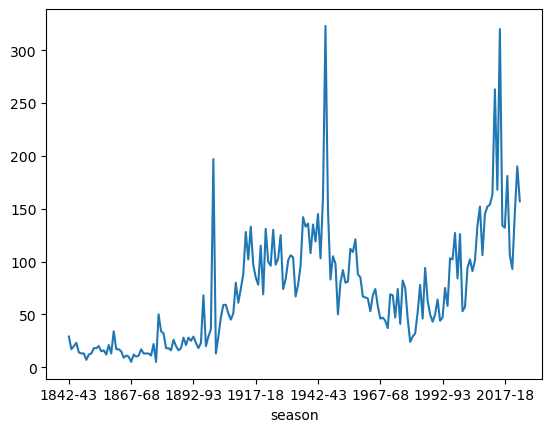

In [49]:
# Remove rows with no 'work_id'; remove intermission rows ('work_id' = '0*'); set index to be a combination of 'work_id' and 'program_id'; reorder and select relevant columns.
work_history_df_cleaned = (
    work_history_df[(work_history_df['work_id'] != '') & (work_history_df['work_id'] != '0') & (work_history_df['work_id'] != '')]
    .set_index(['work_id', 'program_id'])
    .sort_values(['work_id', 'date'], ascending=[True, True])
    .loc[:,['date', 'season', 'work_title','work_movement','work_composer_name']]
    )

# Filter dataframe for only the first performance of a work
new_work_df = (work_history_df_cleaned
                .groupby('work_id')
                .first()
                .sort_values(by='date'))

# Count the number of new works performed in an orchestral season
new_work_per_season = new_work_df.season.value_counts()
new_work_per_season.sort_index(inplace=True)

# Plot the number of new works performed per season
new_work_per_season.plot(x="season", y='count', kind="line")


<Axes: xlabel='season'>

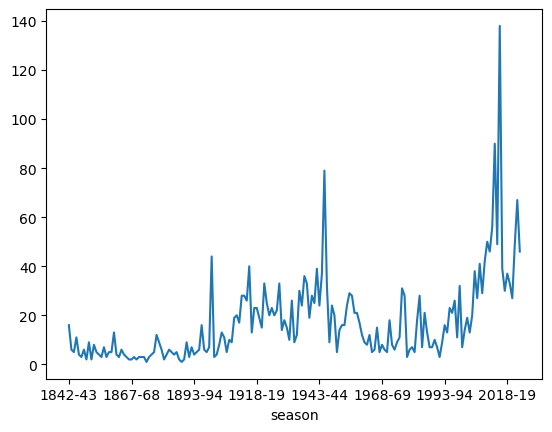

In [51]:
# Remove rows with no composer history; change index to be a combination of composer name, work id, and program id; reorder and select relevant columns
composer_history_df_cleaned = (work_history_df[(work_history_df['work_composer_name'] != '')]
                            .set_index(['work_composer_name','work_id', 'program_id'])
                            .sort_values(['work_composer_name', 'date'])
                            .loc[:,['date','season','work_title','work_movement']]
    )

# Filter data frame for only the first time a composer is performed by the orchestra
new_composer_df = (composer_history_df_cleaned
                        .groupby('work_composer_name')
                        .first()
                        .sort_values(by='date'))

# Count the number of new composers performed in each season
new_composer_per_season = new_composer_df.season.value_counts()
new_composer_per_season.sort_index(inplace=True)

# Plot the number of new composers perfomed in each season
new_composer_per_season.plot(x="season", y='count', kind="line")